#  Análise de Clusters: Os 4 Perfis da Saúde Pública no Brasil

**Objetivo:** Este estudo utiliza algoritmos não-supervisionados (K-Means) para segmentar os 5.570 municípios brasileiros não por fronteiras geográficas, mas por similaridade socioeconômica e sanitária. Buscamos identificar padrões de eficiência, vulnerabilidade e gestão.

**Metodologia:**
1. **Clusterização (K-Means):** Para agrupar os 5.570 municípios em 4 perfis socioeconômicos.
2. **Análise Espacial:** Visualização geográfica dos clusters ("Riqueza Desequilibrada", "Vulnerabilidade", etc).
3. **Detecção de Anomalias (Deep Learning):** Uso de Redes Neurais (Autoencoders) para encontrar casos atípicos (Outliers).

## Fase 1: Agrupamento de Municípios (Clustering)
Utilizamos o algoritmo **K-Means** (Não-Supervisionado) para agrupar cidades.
Para evitar viés, definimos matematicamente o número ideal de grupos usando o **Método do Cotovelo (Elbow Method)** e visualizamos a separação usando **PCA (Análise de Componentes Principais)**.

In [2]:
!pip install geopandas numpy matplotlib seaborn scikit-learn yellowbrick mapclassify geobr tensorflow

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import geobr

sns.set(style="whitegrid")
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore') # Remove avisos de depreciação para limpar a tela

In [21]:
# Lê o arquivo garantindo que o código IBGE seja texto (para não perder o zero à esquerda)
df = pd.read_csv('DATASET_MESTRE_FINAL.csv', dtype={'cod_ibge_6': str})

# Selecionamos as colunas (Features)
features_ml = [
    'pib_per_capita',           # Riqueza
    'taxa_mortalidade_infantil',# Resultado Saúde
    'pct_prenatal',             # Prevenção
    'pct_icsap',                # Má Gestão (Internações evitáveis)
    'custo_medio',              # Eficiência Financeira
    'pct_violencia'             # Contexto Social
]

# Cria um dataframe só para o ML
df_ml = df[features_ml].copy()

# Limpeza:
# 1. Troca "infinito" por Nulo
df_ml = df_ml.replace([np.inf, -np.inf], np.nan)
# 2. Preenche Nulos com a MEDIANA (mais seguro que média)
df_ml = df_ml.fillna(df_ml.median())

print(f"Dataset pronto para ML! Dimensões: {df_ml.shape}")
print("Verificando se sobrou nulo:", df_ml.isnull().sum().sum()) # Tem que dar 0 (obrigatório!!!)

Dataset pronto para ML! Dimensões: (5570, 6)
Verificando se sobrou nulo: 0


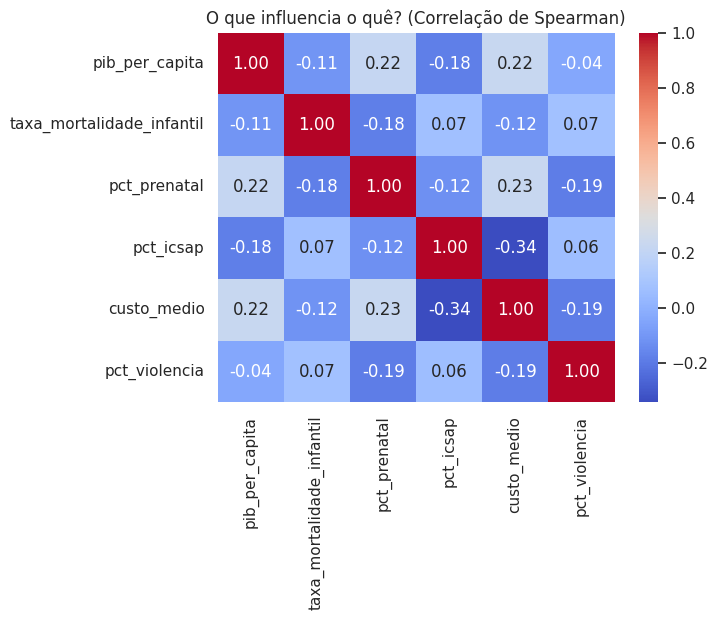

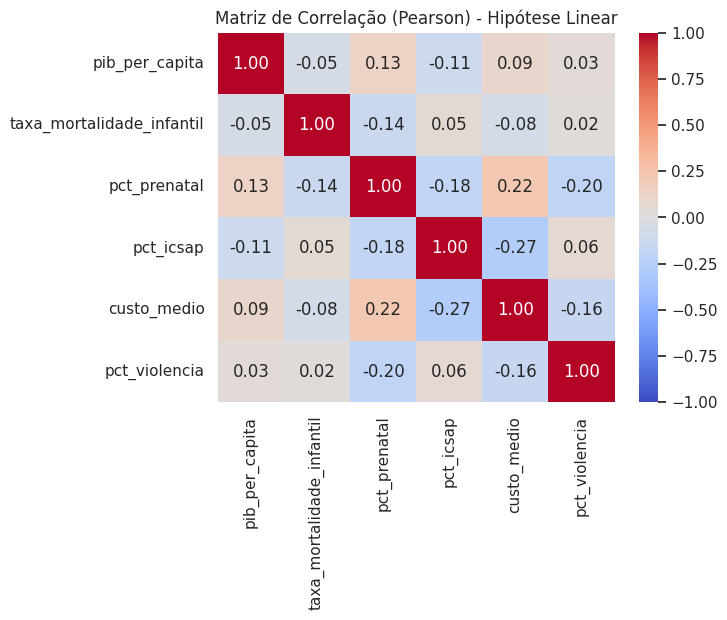

In [22]:
# Matriz de Correlação

# Matriz de Correlação de Spearman (melhor para dados sociais que não são lineares perfeitos)
corr = df_ml.corr(method='spearman') 

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("O que influencia o quê? (Correlação de Spearman)")
plt.show()

# Matriz de Correlação de Pearson (quero comparar)
corr_pearson = df_ml.corr(method='pearson') 

sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Matriz de Correlação (Pearson) - Hipótese Linear")
plt.show()

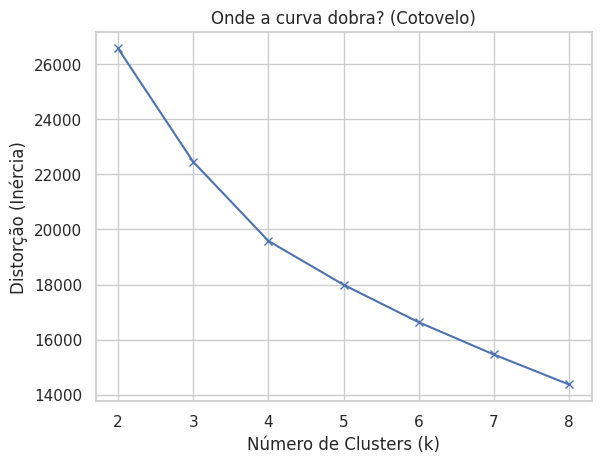

In [23]:
# Método do Cotovelo (Escala + Loop)

# Normalização
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_ml)

# Loop de Teste (Testa de 2 a 8 grupos)
inertias = []
K_range = range(2, 9)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=1, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_) # Erro quadrático

# Gráfico
plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Distorção (Inércia)')
plt.title('Onde a curva dobra? (Cotovelo)')
plt.grid(True)
plt.show()

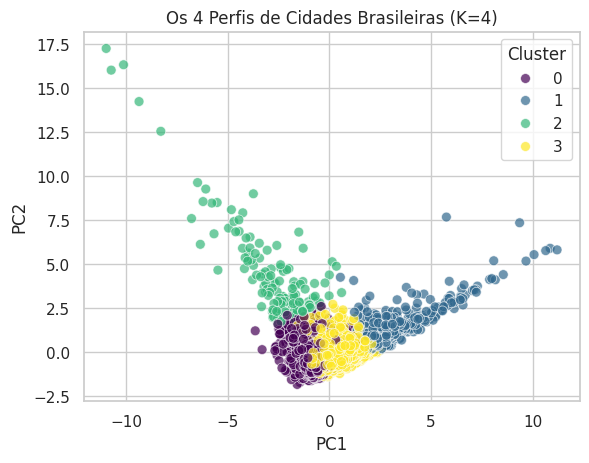

In [24]:
# Clustering Final e PCA

# Aplica o Modelo (Definindo 4 grupos)
k_final = 4
kmeans = KMeans(n_clusters=k_final, random_state=1, n_init=10)

# Salva o resultado no DataFrame original (dataset mestre) para podermos ler depois
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualização PCA (Reduz 6 dimensões para 2 para podermos enxergar)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Salva coordenadas do gráfico
df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]

# Plota
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=50, alpha=0.7)
plt.title(f'Os 4 Perfis de Cidades Brasileiras (K={k_final})')
plt.show()

## Fase 2: Análise Geográfica da Saúde
Aqui traduzimos os grupos matemáticos em mapas reais.
Identificamos fenômenos como a **"Riqueza Desequilibrada"** e a **"Crise de Gestão"**, permitindo uma análise regionalizada das políticas públicas.

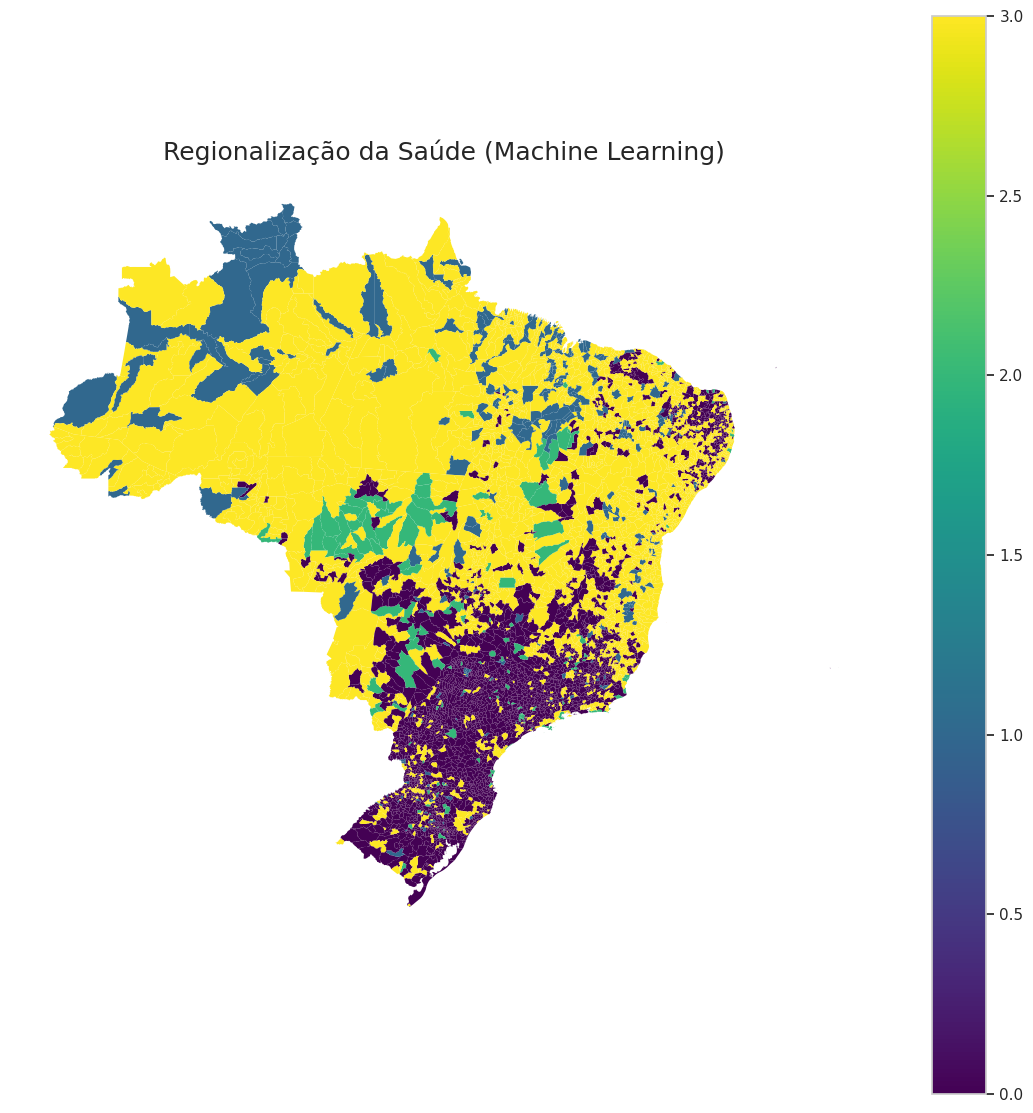

In [25]:
# Mapa Geoespacial
try:
    # Baixa mapa oficial
    mapa = geobr.read_municipality(code_muni="all", year=2020)
    
    # Ajusta código para bater com nosso dataset (6 dígitos)
    mapa['cod_ibge_6'] = mapa['code_muni'].astype(str).str.slice(0, 6)
    
    # Junta os dados
    mapa_final = mapa.merge(df[['cod_ibge_6', 'Cluster']], on='cod_ibge_6', how='inner')
    
    # Plota
    f, ax = plt.subplots(figsize=(14, 14))
    mapa_final.plot(
        column='Cluster', 
        cmap='viridis', 
        legend=True, 
        ax=ax, 
        edgecolor='none' # Remove bordas para ficar mais limpo
    )
    ax.set_title('Regionalização da Saúde (Machine Learning)', fontsize=18)
    ax.axis('off')
    plt.show()
    
    # Salva os dados finais processados
    df.to_csv('DATASET_CLUSTERIZADO.csv', index=False)

except Exception as e:
    print(f"Erro no mapa: {e}")

In [26]:
# Profiling dos Clusters

# Calculando o perfil médio de cada grupo

# Agrupa e Calcula Médias
perfil = df.groupby('Cluster')[features_ml].mean()

# Adiciona contagem de cidades
perfil['n_cidades'] = df['Cluster'].value_counts()

# Ordena pelo PIB (do mais rico pro mais pobre)
perfil = perfil.sort_values(by='pib_per_capita', ascending=False)

# Mostra a tabela formatada com 2 casas decimais, mas sem cores
display(perfil.round(2))

,pib_per_capita,taxa_mortalidade_infantil,pct_prenatal,pct_icsap,custo_medio,pct_violencia,n_cidades
Cluster,,,,,,,
2,208195.39,10.61,80.16,3.08,1483.65,13.48,156
0,43899.58,10.67,84.09,2.52,1856.16,8.03,2801
3,26800.84,15.43,72.49,3.90,1248.69,13.08,2278
1,24528.72,15.75,68.87,16.30,1038.67,11.73,335


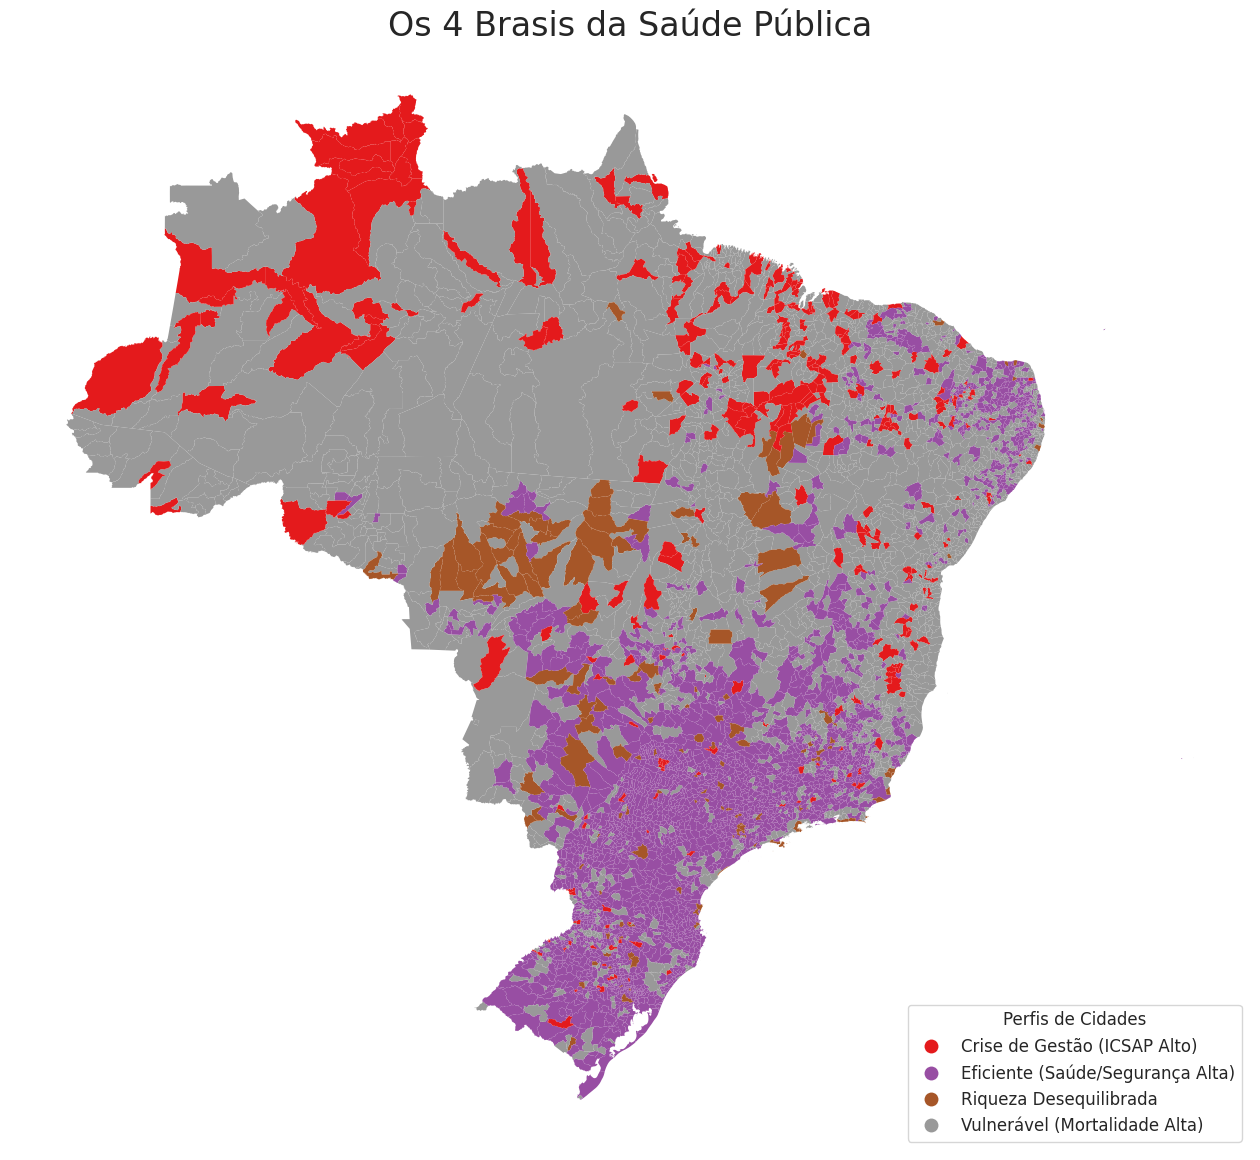

In [27]:
# Mapa Final com Nomes

# Dicionário de Nomes (Baseado na nossa análise)
# Mapeia: Número do Cluster -> Nome Bonito
nomes_clusters = {
    2: 'Riqueza Desequilibrada',
    0: 'Eficiente (Saúde/Segurança Alta)',
    3: 'Vulnerável (Mortalidade Alta)',
    1: 'Crise de Gestão (ICSAP Alto)'
}

# Cria a coluna de nomes no DataFrame
df['Perfil'] = df['Cluster'].map(nomes_clusters)

# Gera o Mapa
try:
    # Baixa mapa (se ainda não tiver baixado na memória)
    if 'mapa' not in locals():
        mapa = geobr.read_municipality(code_muni="all", year=2020)
        mapa['cod_ibge_6'] = mapa['code_muni'].astype(str).str.slice(0, 6)
    
    # Merge com os Nomes
    mapa_final = mapa.merge(df[['cod_ibge_6', 'Perfil']], on='cod_ibge_6', how='inner')
    
    # Plot
    f, ax = plt.subplots(figsize=(16, 16))
    mapa_final.plot(
        column='Perfil', 
        cmap='Set1',      # Paleta de cores bem distintas
        legend=True, 
        legend_kwds={'loc': 'lower right', 'fontsize': 12, 'title': 'Perfis de Cidades'},
        ax=ax, 
        edgecolor='none'
    )
    
    ax.set_title('Os 4 Brasis da Saúde Pública', fontsize=24)
    ax.axis('off')
    
    plt.savefig('mapa_final.png', dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"Erro no mapa: {e}")

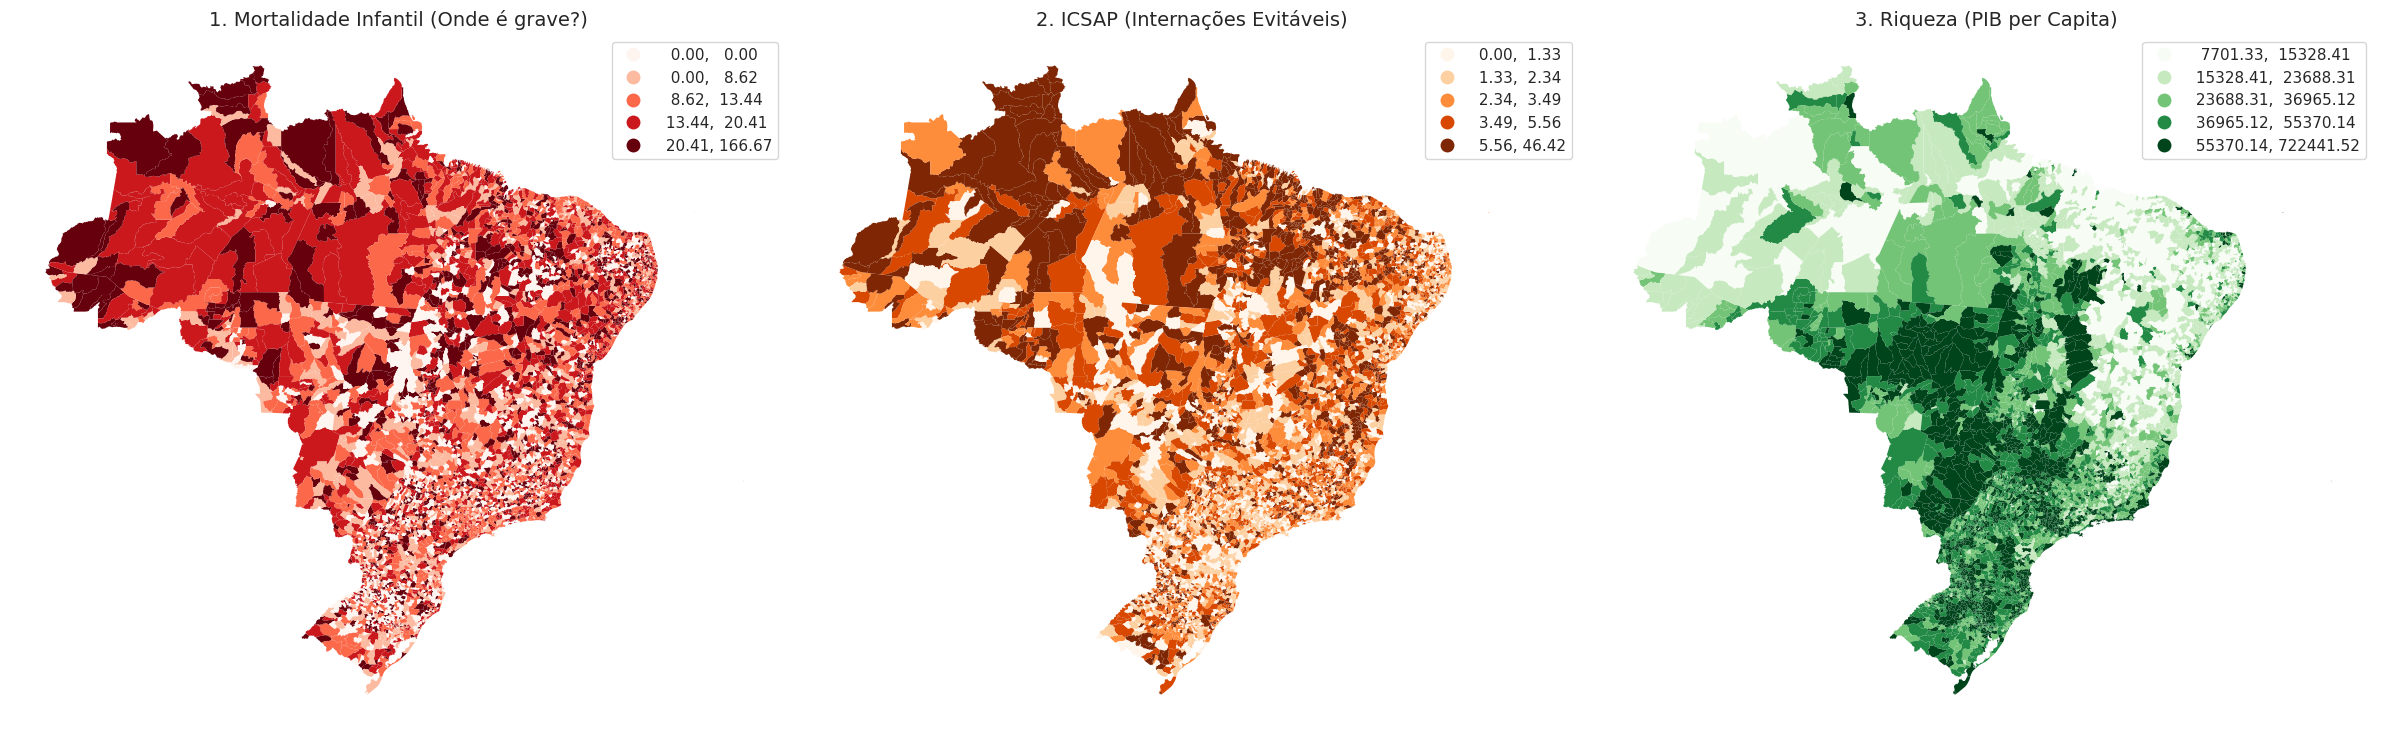

In [28]:
# Comparativo Visual das Variáveis
import matplotlib.pyplot as plt

# Garante que temos o mapa base carregado
if 'mapa' not in locals():
    mapa = geobr.read_municipality(code_muni="all", year=2020)
    mapa['cod_ibge_6'] = mapa['code_muni'].astype(str).str.slice(0, 6)

# Garante o merge com os dados numéricos originais
cols_to_map = ['cod_ibge_6', 'taxa_mortalidade_infantil', 'pct_icsap', 'pib_per_capita']
mapa_var = mapa.merge(df[cols_to_map], on='cod_ibge_6', how='inner')

# Cria uma figura com 3 mapas lado a lado
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Mapa 1: Mortalidade Infantil (Onde morrem bebês?)
mapa_var.plot(column='taxa_mortalidade_infantil', 
              cmap='Reds', 
              legend=True,
              ax=axs[0], 
              edgecolor='none',
              scheme='quantiles')
axs[0].set_title('1. Mortalidade Infantil (Onde é grave?)', fontsize=14)
axs[0].axis('off')

# Mapa 2: ICSAP (Onde a gestão falha?)
mapa_var.plot(column='pct_icsap', 
              cmap='Oranges', 
              legend=True, 
              ax=axs[1], 
              edgecolor='none',
              scheme='quantiles')
axs[1].set_title('2. ICSAP (Internações Evitáveis)', fontsize=14)
axs[1].axis('off')

# Mapa 3: PIB per Capita (Onde está o dinheiro?)
mapa_var.plot(column='pib_per_capita', 
              cmap='Greens', 
              legend=True, 
              ax=axs[2], 
              edgecolor='none',
              scheme='quantiles')
axs[2].set_title('3. Riqueza (PIB per Capita)', fontsize=14)
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [29]:
# Buscador de Cidades
# exemplo: 'nome_cidade - sigla_estado'
cidade_alvo = "São Paulo - SP" 

# Busca
resultado = df[df['mun'] == cidade_alvo][['mun', 'pib_per_capita', 'taxa_mortalidade_infantil', 'Cluster', 'Perfil']]

if not resultado.empty:
    display(resultado)
else:
    print(f"Cidade '{cidade_alvo}' não encontrada. Tente checar acentos ou maiúsculas.")

,mun,pib_per_capita,taxa_mortalidade_infantil,Cluster,Perfil
3829,São Paulo - SP,93156.23,10.88,0,Eficiente (Saúde/Segurança Alta)


In [30]:
# Exportar Resultados
df.to_csv('Resultado_Final_Saude_Brasil.csv', index=False, sep=';', decimal=',')
df.head()

,cod,mun,populacao,pib_total,pib_per_capita,cod_ibge_6,internacoes,icsap,obitos,custo_total,...,taxa_internacao,pct_icsap,custo_medio,taxa_mortalidade_infantil,pct_violencia,pct_prenatal,Cluster,PC1,PC2,Perfil
0,1100015,Alta Floresta D'Oeste - RO,21494,1046343000,48680.70,110001,934,59,17,458763.89,...,43.45,6.32,491.18,5.43,10.50,80.43,3,0.75,0.75,Vulnerável (Mortalidade Alta)
1,1100023,Ariquemes - RO,96833,4383815000,45271.91,110002,1692,68,40,2621797.22,...,17.47,4.02,1549.53,21.26,15.43,78.74,3,0.03,0.22,Vulnerável (Mortalidade Alta)
2,1100031,Cabixi - RO,5351,300832000,56219.77,110003,80,3,4,87751.56,...,14.95,3.75,1096.89,0.00,11.90,95.31,0,-0.43,0.45,Eficiente (Saúde/Segurança Alta)
3,1100049,Cacoal - RO,86887,3848468000,44292.79,110004,2254,116,65,1886942.39,...,25.94,5.15,837.15,9.61,11.09,84.04,3,0.39,0.41,Vulnerável (Mortalidade Alta)
4,1100056,Cerejeiras - RO,15890,1006389000,63334.74,110005,383,33,5,323193.02,...,24.10,8.62,843.85,3.68,16.24,81.25,3,0.98,1.52,Vulnerável (Mortalidade Alta)


Gerando os 4 mapas isolados...


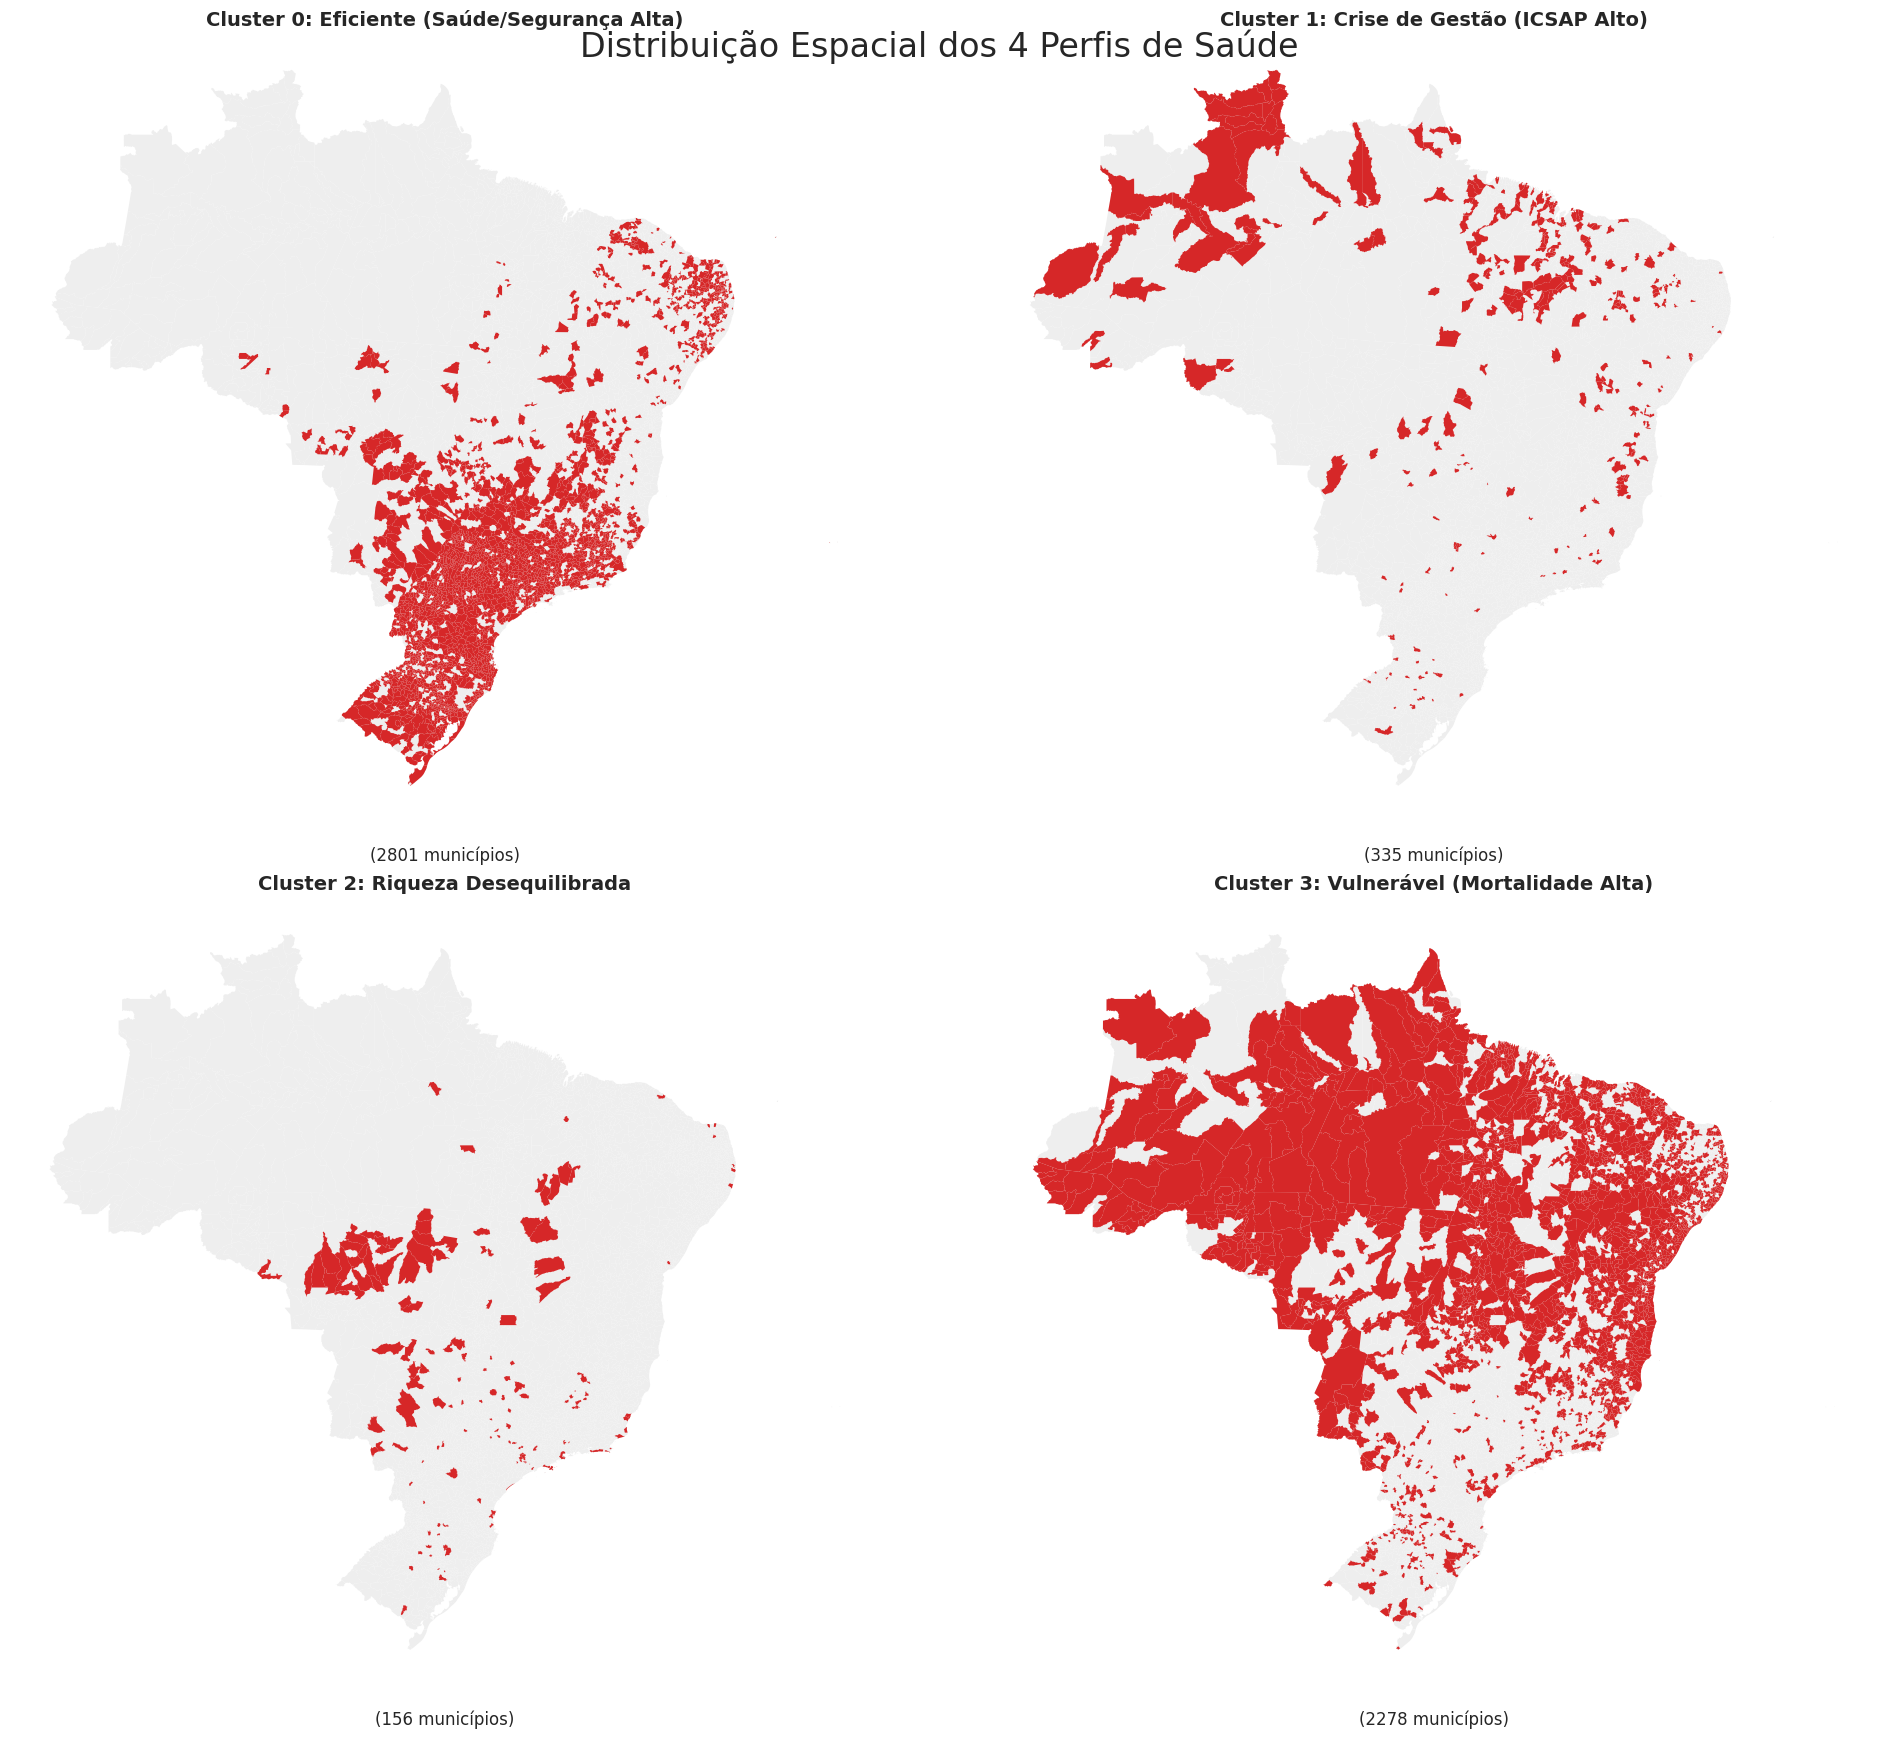

In [31]:
# Painel de 4 Mapas

# Garante que temos a malha geográfica bruta
if 'mapa' not in locals():
    mapa = geobr.read_municipality(code_muni="all", year=2020)
    mapa['cod_ibge_6'] = mapa['code_muni'].astype(str).str.slice(0, 6)

cols_to_merge = ['cod_ibge_6', 'Cluster', 'Perfil']
mapa_final = mapa.merge(df[cols_to_merge], on='cod_ibge_6', how='inner')

# Configura a figura
fig, axs = plt.subplots(2, 2, figsize=(20, 18))
axs = axs.flatten()
lista_clusters = sorted(df['Cluster'].unique())

print("Gerando os 4 mapas isolados...")

for i, cluster_id in enumerate(lista_clusters):
    ax = axs[i]
    
    # Pega o nome do perfil
    try:
        nome_perfil = nomes_clusters[cluster_id]
    except:
        nome_perfil = f"Cluster {cluster_id}"
    
    # A. Fundo Cinza (Brasil todo)
    mapa_final.plot(ax=ax, color='#eeeeee', edgecolor='none')
    
    # B. Destaque Vermelho (Só o cluster atual)
    subset = mapa_final[mapa_final['Cluster'] == cluster_id]
    subset.plot(ax=ax, color='#d62728', edgecolor='none')
    
    # C. Estética
    ax.set_title(f"Cluster {cluster_id}: {nome_perfil}", fontsize=14, fontweight='bold')
    ax.axis('off')
    
    # Contador
    qtd = len(subset)
    ax.text(0.5, -0.05, f"({qtd} municípios)", transform=ax.transAxes, ha='center', fontsize=12)

plt.suptitle('Distribuição Espacial dos 4 Perfis de Saúde', fontsize=24, y=0.95)
plt.tight_layout()
plt.show()

## Fase 3: Buscando Anomalias com Deep Learning
Médias escondem segredos. Para encontrar as cidades mais "estranhas" do Brasil, treinamos um **Autoencoder** (Rede Neural).

**Como funciona:**
A IA tenta aprender o que é uma cidade "normal". Quando ela falha em reconstruir os dados de uma cidade específica (Erro de Reconstrução alto), sabemos que encontramos uma **Anomalia** — um caso que merece estudo de caso aprofundado (ex: Lagoa Santa/GO).

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


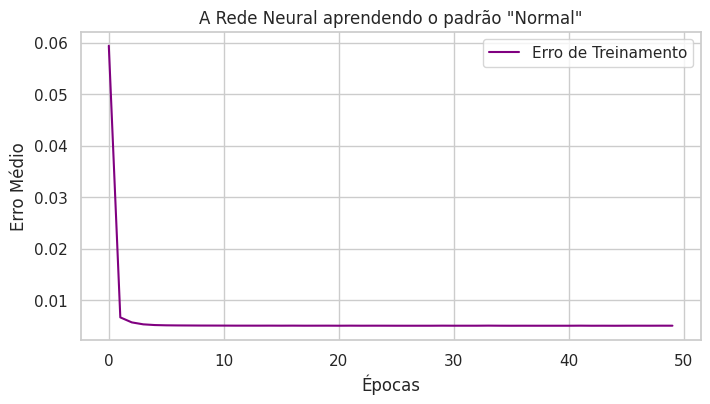


 TOP 10 CIDADES MAIS ATÍPICAS (ANOMALIAS)


,mun,Erro_Reconstrucao,pib_per_capita,taxa_mortalidade_infantil,Cluster
5455,Lagoa Santa - GO,0.19,48382.01,0.00,1
3255,Saquarema - RJ,0.15,722441.52,8.81,2
2183,São Francisco do Conde - BA,0.14,684319.24,18.56,2
5084,Vanini - RS,0.14,40780.44,166.67,3
1940,Cravolândia - BA,0.14,13069.76,65.22,1
3215,Maricá - RJ,0.13,679714.48,9.85,2
583,Passagem Franca - MA,0.13,12021.72,15.04,1
609,Sambaíba - MA,0.12,77826.87,0.00,1
1229,Tenente Ananias - RN,0.12,13914.93,9.62,1
516,Duque Bacelar - MA,0.12,10637.58,12.20,1


In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Preparação dos Dados
# MinMaxScaler para colocar tudo entre 0 e 1
scaler_dl = MinMaxScaler()
X_dl = scaler_dl.fit_transform(df_ml)

# Arquitetura da Rede Neural
# Entrada (6) -> Encoder (4) -> Bottleneck (2) -> Decoder (4) -> Saída (6)
input_dim = X_dl.shape[1]

input_layer = Input(shape=(input_dim,))
encoder = Dense(4, activation="relu")(input_layer)

# A rede é forçada a resumir a cidade em apenas 2 números
bottleneck = Dense(2, activation="relu", name="latent_space")(encoder)

decoder = Dense(4, activation="relu")(bottleneck)
# Sigmoid na saída garante que o resultado fique entre 0 e 1
output_layer = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compilação e Tunning
# Learning Rate de 0.005
optimizer = Adam(learning_rate=0.005)
autoencoder.compile(optimizer=optimizer, loss='mse')

# Treinamento
history = autoencoder.fit(
    X_dl, X_dl,       # a rede tenta prever a PRÓPRIA entrada
    epochs=50,        # número de vezes que ela vê os dados
    batch_size=32,    # quantas cidades ela estuda por vez
    shuffle=True,
    verbose=0         # Modo silencioso
)

# Detecção de Anomalias
# Pedimos para a rede reconstruir as cidades.
reconstrucoes = autoencoder.predict(X_dl)

# Calculamos o ERRO: Diferença entre a Realidade e o que a Rede entendeu
# Se o erro for alto, a cidade é uma anomalia (algo que a rede nunca viu igual)
mse = np.mean(np.power(X_dl - reconstrucoes, 2), axis=1)
df['Erro_Reconstrucao'] = mse

# Visualização do Aprendizado
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Erro de Treinamento', color='purple')
plt.title('A Rede Neural aprendendo o padrão "Normal"')
plt.xlabel('Épocas')
plt.ylabel('Erro Médio')
plt.legend()
plt.show()

# Revelando os "Cisnes Negros"
top_anomalias = df.sort_values(by='Erro_Reconstrucao', ascending=False).head(10)

print("\n TOP 10 CIDADES MAIS ATÍPICAS (ANOMALIAS)")
cols_to_show = ['mun', 'Erro_Reconstrucao', 'pib_per_capita', 'taxa_mortalidade_infantil', 'Cluster']
display(top_anomalias[cols_to_show])

In [33]:
# Seleciona as colunas principais para não ficar um arquivo gigante
cols_export = [
    'cod_ibge_6', 'mun', 'Cluster', 'Perfil', 'Erro_Reconstrucao', 'pib_per_capita', 'taxa_mortalidade_infantil', 'pct_prenatal', 'pct_icsap', 'pct_violencia'
]

try:
    df_final = df[cols_export].copy()
    
    # Cria uma coluna de "Flag Anomalia" para facilitar a visualização
    # Quem estiver no Top 1% de erro ganha um "SIM"
    limite_anomalia = df_final['Erro_Reconstrucao'].quantile(0.99)
    df_final['Eh_Anomalia'] = df_final['Erro_Reconstrucao'] > limite_anomalia
    df_final.to_csv('DATASET_final.csv', index=False, sep=';', decimal=',')
    print('Deu certo!')
    
except Exception as e:
    print(f"Erro ao salvar: {e}")

Deu certo!


## Conclusões e Trabalhos Futuros
O estudo demonstrou que o PIB per capita, isoladamente, não garante eficiência em saúde.
A identificação de anomalias via Deep Learning abriu portas para investigar "milagres" (cidades pobres e eficientes) e "desastres" (cidades ricas e ineficientes).

**Próximos Passos:**
* Implementar modelos de Causalidade (XGBoost + SHAP) para entender o peso de cada variável.
* Analisar a série temporal para ver a evolução desses clusters na última década.